# Importing Libraries

## Core

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

## NLP

In [2]:
from transformers import  AutoTokenizer, AutoModelForSequenceClassification, pipeline, TFAutoModelForSequenceClassification
import tensorflow as tf
import torch

## Plotting

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [4]:
import yfinance as yf
import requests

## Others

In [5]:
from tqdm import tqdm
import re
import os
import warnings
warnings.filterwarnings('ignore')

# Fetching Data

In [6]:
news_df=pd.read_csv("/content/cnbc_headlines.csv")
news_df.head()

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


In [7]:
news_df.dropna(inplace=True)
news_df['Time'] = pd.to_datetime(news_df['Time']).dt.date
news_df.rename(columns={'Time': 'Date'}, inplace=True)
news_df.sort_values(by='Date', inplace=True)
news_df.head()

,Headlines,Date,Description
3079,Cramer: Never buy a stock all at once — you'll...,2017-12-22,Jim Cramer doubled down on his key investing r...
3078,Cramer: I helped investors through the 2010 fl...,2017-12-22,"Jim Cramer built on his ""nobody ever made a di..."
3077,Cramer says owning too many stocks and too lit...,2017-12-22,Jim Cramer broke down why owning fewer stocks ...
3075,Markets lack Christmas cheer,2017-12-26,"According to Kensho, here's how markets have f..."
3074,S&P tends to start new year bullish after this...,2017-12-27,The S&P is on track to end the year up 20 perc...


In [8]:
def get_stock_data(ticker, start='2017-12-22', end='2020-07-17'):
    df = yf.download(ticker, start=start, end=end)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df = df.reset_index(drop=True) # Reset the index to a single level
    return df[['Date', 'Close']]

In [9]:
stock_df = get_stock_data("AAPL")
stock_df.columns = [col[0] for col in stock_df.columns]
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2017-12-22,41.072208
1,2017-12-26,40.030212
2,2017-12-27,40.037254
3,2017-12-28,40.149891
4,2017-12-29,39.715721


In [10]:
stock_df.to_csv("Apple.csv")

# Sentiment Labels Using FinBERT



In [11]:
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [12]:
news_df["Content"] = news_df["Headlines"].astype(str) + " " + news_df["Description"].astype(str)
news_df.head()

,Headlines,Date,Description,Content
3079,Cramer: Never buy a stock all at once — you'll...,2017-12-22,Jim Cramer doubled down on his key investing r...,Cramer: Never buy a stock all at once — you'll...
3078,Cramer: I helped investors through the 2010 fl...,2017-12-22,"Jim Cramer built on his ""nobody ever made a di...",Cramer: I helped investors through the 2010 fl...
3077,Cramer says owning too many stocks and too lit...,2017-12-22,Jim Cramer broke down why owning fewer stocks ...,Cramer says owning too many stocks and too lit...
3075,Markets lack Christmas cheer,2017-12-26,"According to Kensho, here's how markets have f...",Markets lack Christmas cheer According to Kens...
3074,S&P tends to start new year bullish after this...,2017-12-27,The S&P is on track to end the year up 20 perc...,S&P tends to start new year bullish after this...


In [13]:
grouped_df = news_df.groupby('Date').agg({
    'Content': lambda x: ' '.join(x.astype(str))
}).reset_index()
grouped_df.head()

,Date,Content
0,2017-12-22,Cramer: Never buy a stock all at once — you'll...
1,2017-12-26,Markets lack Christmas cheer According to Kens...
2,2017-12-27,S&P tends to start new year bullish after this...
3,2018-01-02,Cramer Remix: Apple's stock won't slow down in...
4,2018-01-03,Markets after S&P gains 15% in a year Accordin...


In [14]:
def classify_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model(inputs)
    probs = tf.nn.softmax(outputs.logits, axis=1)
    classes = ['negative', 'neutral', 'positive']
    results = [classes[i] for i in tf.argmax(probs, axis=1).numpy()]
    return results

In [15]:
tqdm.pandas()
grouped_df["Sentiment"] = grouped_df["Content"].astype(str).progress_apply(
    lambda x: classify_sentiment([x])[0])

100%|██████████| 612/612 [13:23<00:00,  1.31s/it]


# Merge with Stock Price Movement Labels

In [16]:
def label_movement(x):
    if x > 0.5:
        return "UP"
    elif x < -0.5:
        return "DOWN"
    else:
        return "NEUTRAL"

In [17]:
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
merged = pd.merge(grouped_df, stock_df, on='Date', how='inner')
merged['next_day_close'] = merged['Close'].shift(-1)
merged['pct_change'] = ((merged['next_day_close'] - merged['Close']) / merged['Close']) * 100

In [18]:
merged['movement'] = merged['pct_change'].apply(label_movement)
merged = merged.dropna(subset=['movement'])
merged.head()

,Date,Content,Sentiment,Close,next_day_close,pct_change,movement
0,2017-12-22,Cramer: Never buy a stock all at once — you'll...,negative,41.072208,40.030212,-2.536986,DOWN
1,2017-12-26,Markets lack Christmas cheer According to Kens...,negative,40.030212,40.037254,0.017592,NEUTRAL
2,2017-12-27,S&P tends to start new year bullish after this...,neutral,40.037254,40.426819,0.973005,UP
3,2018-01-02,Cramer Remix: Apple's stock won't slow down in...,neutral,40.426819,40.419785,-0.017400,NEUTRAL
4,2018-01-03,Markets after S&P gains 15% in a year Accordin...,neutral,40.419785,40.607536,0.464505,NEUTRAL


# Feature Engineering + Model Training

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [21]:
max_vocab = 5000
max_len = 300
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(merged['Content'])
X_seq = tokenizer.texts_to_sequences(merged['Content'])
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

In [22]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged['movement'])
y_cat = to_categorical(y, num_classes=3)

## Train Test Split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_cat, test_size=0.2, random_state=42)

# LSTM Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64
max_vocab = 5000
max_len = 300
num_classes = 3

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/10
14/14 - 5s - 387ms/step - accuracy: 0.4033 - loss: 1.0930 - val_accuracy: 0.3750 - val_loss: 1.0995
Epoch 2/10
14/14 - 2s - 153ms/step - accuracy: 0.4222 - loss: 1.0846 - val_accuracy: 0.3750 - val_loss: 1.1010
Epoch 3/10
14/14 - 2s - 159ms/step - accuracy: 0.4222 - loss: 1.0815 - val_accuracy: 0.3750 - val_loss: 1.1071
Epoch 4/10
14/14 - 3s - 234ms/step - accuracy: 0.4198 - loss: 1.0782 - val_accuracy: 0.3750 - val_loss: 1.1090
Epoch 5/10
14/14 - 4s - 279ms/step - accuracy: 0.4222 - loss: 1.0831 - val_accuracy: 0.3750 - val_loss: 1.1106
Epoch 6/10
14/14 - 2s - 150ms/step - accuracy: 0.4245 - loss: 1.0792 - val_accuracy: 0.3750 - val_loss: 1.1082
Epoch 7/10
14/14 - 3s - 180ms/step - accuracy: 0.4245 - loss: 1.0866 - val_accuracy: 0.3750 - val_loss: 1.1010
Epoch 8/10
14/14 - 4s - 255ms/step - accuracy: 0.4245 - loss: 1.0836 - val_accuracy: 0.3750 - val_loss: 1.1057
Epoch 9/10
14/14 - 2s - 172ms/step - accuracy: 0.4245 - loss: 1.0782 - val_accuracy: 0.3750 - val_loss: 1.0996
E

In [26]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.42


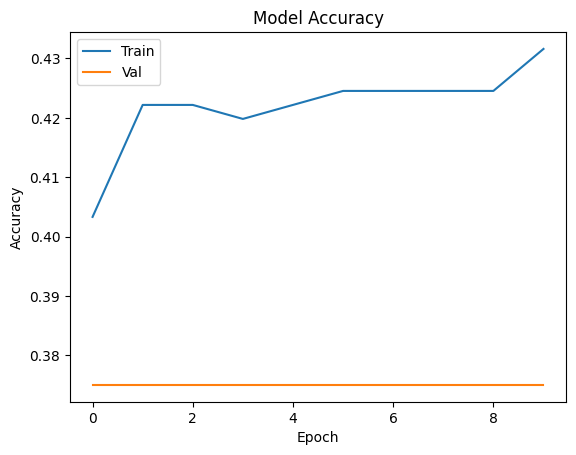

In [27]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Improving Model

## Bidirectional LSTM

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

embedding_dim = 64
max_vocab = 5000
max_len = 300
num_classes = 3

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len),

    # Bidirectional LSTM for better context understanding
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    # Second LSTM layer (stacked)
    LSTM(32, return_sequences=False),
    Dropout(0.3),

    # Dense layers
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(num_classes, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/10
14/14 - 15s - 1s/step - accuracy: 0.2995 - loss: 1.4938 - val_accuracy: 0.3750 - val_loss: 1.0961
Epoch 2/10
14/14 - 7s - 516ms/step - accuracy: 0.3208 - loss: 1.4166 - val_accuracy: 0.3750 - val_loss: 1.0945
Epoch 3/10
14/14 - 7s - 532ms/step - accuracy: 0.3184 - loss: 1.2946 - val_accuracy: 0.3750 - val_loss: 1.0943
Epoch 4/10
14/14 - 9s - 631ms/step - accuracy: 0.3255 - loss: 1.3427 - val_accuracy: 0.3750 - val_loss: 1.0947
Epoch 5/10
14/14 - 7s - 529ms/step - accuracy: 0.3113 - loss: 1.3044 - val_accuracy: 0.3750 - val_loss: 1.0948
Epoch 6/10
14/14 - 9s - 630ms/step - accuracy: 0.3349 - loss: 1.2638 - val_accuracy: 0.3750 - val_loss: 1.0962
Epoch 7/10
14/14 - 10s - 727ms/step - accuracy: 0.3302 - loss: 1.2599 - val_accuracy: 0.3750 - val_loss: 1.0962
Epoch 8/10
14/14 - 10s - 740ms/step - accuracy: 0.4080 - loss: 1.1656 - val_accuracy: 0.3750 - val_loss: 1.0974
Epoch 9/10
14/14 - 12s - 826ms/step - accuracy: 0.3467 - loss: 1.2058 - val_accuracy: 0.3750 - val_loss: 1.0952


In [30]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.42


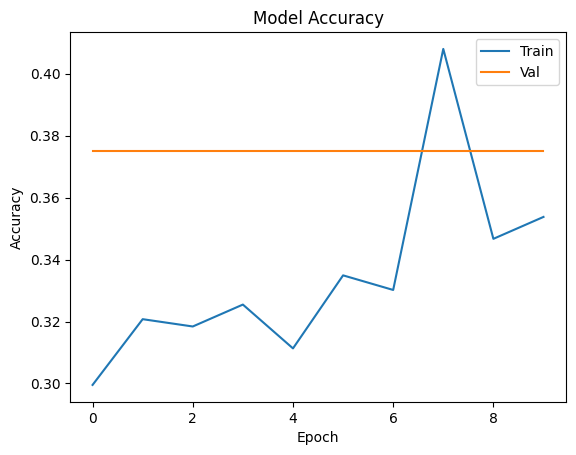

In [31]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Using GloVE Embeddings

 Load GloVe Embeddings (download glove.6B.100d.txt from https://nlp.stanford.edu/projects/glove/)

In [32]:
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

In [33]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_vocab, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]


In [34]:
# Rebuild model with pretrained embeddings

model = Sequential([
    Embedding(input_dim=max_vocab,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # frozen pre-trained embeddings

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(32, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(3, activation='softmax')  # for 3-class classification
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

In [36]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/10
14/14 - 15s - 1s/step - accuracy: 0.3420 - loss: 1.4485 - val_accuracy: 0.3333 - val_loss: 1.0957
Epoch 2/10
14/14 - 5s - 390ms/step - accuracy: 0.3939 - loss: 1.3406 - val_accuracy: 0.3333 - val_loss: 1.0983
Epoch 3/10
14/14 - 10s - 728ms/step - accuracy: 0.3278 - loss: 1.3227 - val_accuracy: 0.3333 - val_loss: 1.1007
Epoch 4/10
14/14 - 7s - 492ms/step - accuracy: 0.3538 - loss: 1.2750 - val_accuracy: 0.3333 - val_loss: 1.1022
Epoch 5/10
14/14 - 9s - 663ms/step - accuracy: 0.3137 - loss: 1.3012 - val_accuracy: 0.3333 - val_loss: 1.1022
Epoch 6/10
14/14 - 10s - 698ms/step - accuracy: 0.3349 - loss: 1.3182 - val_accuracy: 0.3333 - val_loss: 1.1014
Epoch 7/10
14/14 - 7s - 489ms/step - accuracy: 0.3561 - loss: 1.2135 - val_accuracy: 0.3125 - val_loss: 1.1023
Epoch 8/10
14/14 - 10s - 683ms/step - accuracy: 0.3491 - loss: 1.1999 - val_accuracy: 0.3125 - val_loss: 1.1030
Epoch 9/10
14/14 - 10s - 679ms/step - accuracy: 0.3373 - loss: 1.2032 - val_accuracy: 0.3125 - val_loss: 1.1023

In [37]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.29


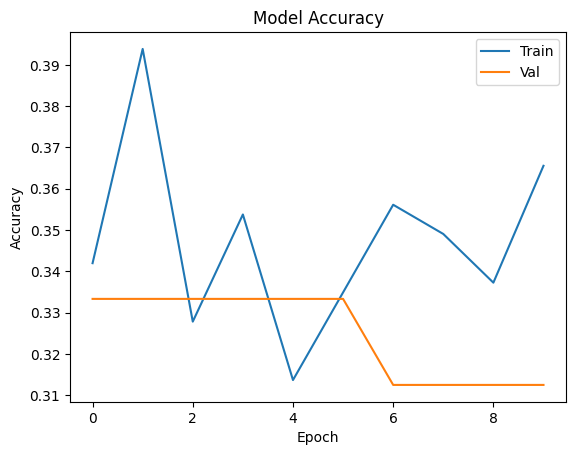

In [38]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Bert Embeddings

In [63]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

In [64]:
# Load SBERT model (lightweight, fast, no GPU needed)
sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Convert each 'content' (or headline) into a 384-d vector
X = sbert.encode(merged['Content'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

In [65]:
le = LabelEncoder()
y_encoded = le.fit_transform(merged['movement'])  # 'UP', 'DOWN', 'NEUTRAL'
y_cat = to_categorical(y_encoded, num_classes=3)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [67]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(384,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/20
14/14 - 2s - 114ms/step - accuracy: 0.4009 - loss: 1.0908 - val_accuracy: 0.3750 - val_loss: 1.0957
Epoch 2/20
14/14 - 0s - 31ms/step - accuracy: 0.4222 - loss: 1.0811 - val_accuracy: 0.3750 - val_loss: 1.0968
Epoch 3/20
14/14 - 0s - 24ms/step - accuracy: 0.4222 - loss: 1.0705 - val_accuracy: 0.3750 - val_loss: 1.1049
Epoch 4/20
14/14 - 0s - 15ms/step - accuracy: 0.4245 - loss: 1.0673 - val_accuracy: 0.3750 - val_loss: 1.1050
Epoch 5/20
14/14 - 0s - 19ms/step - accuracy: 0.4316 - loss: 1.0590 - val_accuracy: 0.3750 - val_loss: 1.1107
Epoch 6/20
14/14 - 1s - 50ms/step - accuracy: 0.4387 - loss: 1.0488 - val_accuracy: 0.3958 - val_loss: 1.1110
Epoch 7/20
14/14 - 0s - 35ms/step - accuracy: 0.4599 - loss: 1.0320 - val_accuracy: 0.3542 - val_loss: 1.1149
Epoch 8/20
14/14 - 1s - 48ms/step - accuracy: 0.4646 - loss: 1.0343 - val_accuracy: 0.3542 - val_loss: 1.1194
Epoch 9/20
14/14 - 0s - 28ms/step - accuracy: 0.5071 - loss: 1.0117 - val_accuracy: 0.3125 - val_loss: 1.1263
Epoch 10/

In [68]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.42


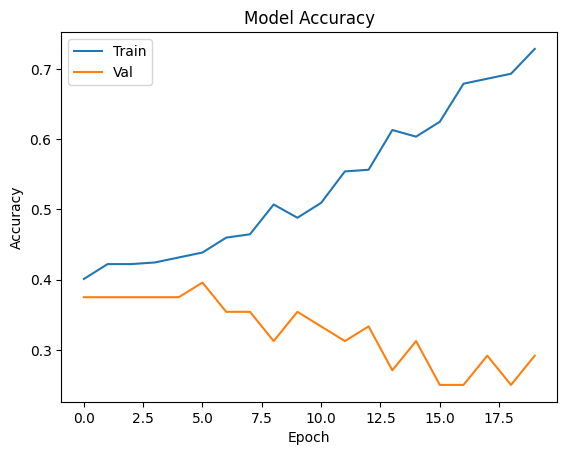

In [69]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Dual Input Model

In [70]:
X_text = sbert.encode(merged['Content'].tolist(), show_progress_bar=True)  # shape: (N, 384)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

In [47]:
merged['return_prev_day'] = merged['Close'].pct_change().fillna(0)
merged['volatility'] = merged['Close'].rolling(window=3).std().fillna(0)

# Select and normalize numeric features
numeric_features = merged[['return_prev_day', 'volatility']].values

In [48]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(numeric_features)

In [49]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged['movement'])
y_cat = to_categorical(y, num_classes=3)

In [50]:
# Split both inputs and output
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_num_scaled, y_cat, test_size=0.2, random_state=42)

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# Text Input
text_input = Input(shape=(384,), name='text_input')
x1 = Dense(128, activation='relu')(text_input)
x1 = Dropout(0.3)(x1)

# Numeric Input
num_input = Input(shape=(X_num_scaled.shape[1],), name='num_input')
x2 = Dense(32, activation='relu')(num_input)
x2 = Dropout(0.3)(x2)

# Combine
combined = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Build model
model = Model(inputs=[text_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     49,280 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │         96 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout_11[0][0], │
│ (Concatenate)       │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 3)         │        195 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,875 (233.89 KB)

 Trainable params: 59,875 (233.89 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(
    {'text_input': X_text_train, 'num_input': X_num_train},
    y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)

Epoch 1/20
14/14 - 2s - 142ms/step - accuracy: 0.3750 - loss: 1.0921 - val_accuracy: 0.3750 - val_loss: 1.0932
Epoch 2/20
14/14 - 0s - 32ms/step - accuracy: 0.4292 - loss: 1.0717 - val_accuracy: 0.3750 - val_loss: 1.1035
Epoch 3/20
14/14 - 0s - 21ms/step - accuracy: 0.4269 - loss: 1.0690 - val_accuracy: 0.3750 - val_loss: 1.1057
Epoch 4/20
14/14 - 0s - 19ms/step - accuracy: 0.4292 - loss: 1.0572 - val_accuracy: 0.3333 - val_loss: 1.1046
Epoch 5/20
14/14 - 0s - 24ms/step - accuracy: 0.4151 - loss: 1.0572 - val_accuracy: 0.3542 - val_loss: 1.0986
Epoch 6/20
14/14 - 0s - 22ms/step - accuracy: 0.4505 - loss: 1.0413 - val_accuracy: 0.3542 - val_loss: 1.1017
Epoch 7/20
14/14 - 0s - 13ms/step - accuracy: 0.4599 - loss: 1.0284 - val_accuracy: 0.3542 - val_loss: 1.1025
Epoch 8/20
14/14 - 0s - 24ms/step - accuracy: 0.4646 - loss: 1.0197 - val_accuracy: 0.3333 - val_loss: 1.1092
Epoch 9/20
14/14 - 0s - 21ms/step - accuracy: 0.5189 - loss: 0.9938 - val_accuracy: 0.3333 - val_loss: 1.1179
Epoch 10/

In [53]:
loss, acc = model.evaluate(
    {'text_input': X_text_test, 'num_input': X_num_test},
    y_test, verbose=0)

print(f"Test Accuracy (Dual Input): {acc:.2f}")

Test Accuracy (Dual Input): 0.42


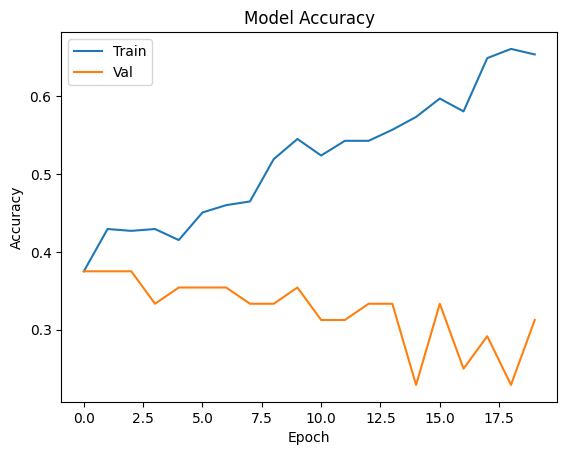

In [54]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## TF-IDF and XGBoost

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

In [56]:
merged['Content'] = merged['Content'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()

In [57]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(merged['Content'])  # shape: (n_samples, 5000)

In [58]:
le = LabelEncoder()
y = le.fit_transform(merged['movement'])  # UP/DOWN/NEUTRAL → 0/1/2

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [61]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.4117647058823529

Classification Report:
               precision    recall  f1-score   support

        DOWN       0.37      0.38      0.37        37
     NEUTRAL       0.24      0.16      0.19        32
          UP       0.50      0.60      0.55        50

    accuracy                           0.41       119
   macro avg       0.37      0.38      0.37       119
weighted avg       0.39      0.41      0.40       119



# GPT Summarizer

In [82]:
import openai
from openai import OpenAI

In [ ]:
client = OpenAI(api_key = "OpenAi API Key")

In [87]:
def generate_market_summary(news_text, movement_text, date_str=None):
    if date_str is None:
        from datetime import date
        date_str = date.today().strftime("%B %d, %Y")

    prompt = f"""
Write a concise and insightful daily market summary for {date_str}.
Consider the following:

📰 News:
{news_text}

📉 Stock Movements:
{movement_text}

Your summary should sound like a financial journalist reporting for Bloomberg or Economic Times.
"""

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a financial analyst and journalist."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=400
    )

    return response.choices[0].message.content

In [77]:
# Filter data for one day
target_date = pd.to_datetime("2017-12-22").date()
daily_news = news_df[news_df['Date'] == target_date]['Content'].tolist()
daily_prices = stock_df[stock_df['Date'] == target_date]['Close'].tolist()

In [78]:
# Prepare input text
news_text = '\n'.join(f"- {headline}" for headline in daily_news[:10])  # top 10 headlines
movement_text = f"The stock closed at ₹{daily_prices[0]:.2f} on {target_date}" if daily_prices else "No price data available."

In [ ]:
summary = generate_market_summary(news_text, movement_text, date_str=str(target_date))
print(summary)

# Hugging Face Transformer Pipeline Summarization

In [90]:
from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

Device set to use cpu


In [91]:
summary = summarizer(news_text, max_length=200, min_length=50, do_sample=False)
print(summary[0]['summary_text'])

Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


Jim Cramer doubled down on his key investing rule of never buying a desired stock all in one go. Cramer says owning too many stocks and too little cash can set you up for failure. He says investors shouldn't be ashamed of having cash on hand.
